In [122]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import datetime
current_timestamp = pd.to_datetime(str(datetime.datetime.now()))

In [123]:
#reading Dataset
retail = pd.read_csv("Online Retail.csv",  sep = ',',encoding = "ANSI", header= 0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [124]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [125]:
frequency = retail.groupby(by = 'CustomerID')[['InvoiceNo']].count()
frequency.columns = ['Frequency']
frequency.head()

,Frequency
CustomerID,
12346.0,2
12347.0,182
12348.0,31
12349.0,73
12350.0,17


In [126]:
recency = retail.groupby(by = 'CustomerID')[['InvoiceDate']].max()
recency['InvoiceDate'] = current_timestamp - recency['InvoiceDate']
recency.columns = ['Recency']
recency.head()

,Recency
CustomerID,
12346.0,2675 days 06:07:54.868144
12347.0,2389 days 03:59:54.868144
12348.0,2425 days 03:11:54.868144
12349.0,2368 days 06:33:54.868144
12350.0,2660 days 00:23:54.868144


In [127]:
retail['Amount'] = retail['UnitPrice'] * retail['Quantity']
monetary = retail.groupby(by = 'CustomerID')[['Amount']].sum()
monetary.head()

,Amount
CustomerID,
12346.0,0.00
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [128]:
### RFM
RFM = recency.join(frequency, how='inner').join(monetary, how='inner')
RFM = RFM.reset_index()
RFM.head()

,CustomerID,Recency,Frequency,Amount
0,12346.0,2675 days 06:07:54.868144,2,0.00
1,12347.0,2389 days 03:59:54.868144,182,4310.00
2,12348.0,2425 days 03:11:54.868144,31,1797.24
3,12349.0,2368 days 06:33:54.868144,73,1757.55
4,12350.0,2660 days 00:23:54.868144,17,334.40


In [129]:
RFM.Amount.describe()

count      4372.000000
mean       1898.459701
std        8219.345141
min       -4287.630000
25%         293.362500
50%         648.075000
75%        1611.725000
max      279489.020000
Name: Amount, dtype: float64

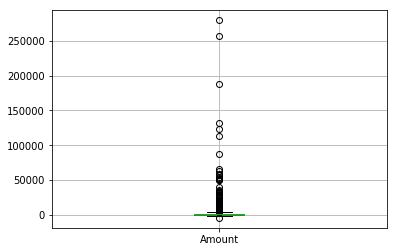

In [130]:
RFM.boxplot(column='Amount')

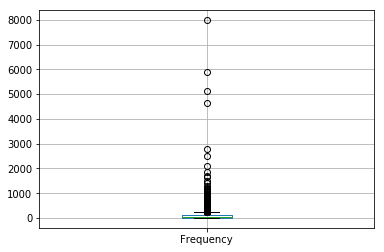

In [131]:
RFM.boxplot(column='Frequency')

In [132]:
# max value of amount is 140 times greater than mean value, so we have to check for outliers
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

# outlier treatment for Recency
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

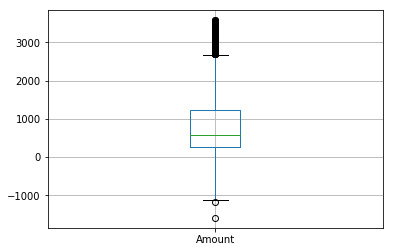

In [133]:
RFM.boxplot(column='Amount')

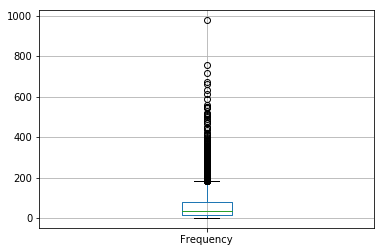

In [134]:
RFM.boxplot(column='Frequency')

In [135]:
RFM.head()

,CustomerID,Recency,Frequency,Amount
0,12346.0,2675 days 06:07:54.868144,2,0.00
2,12348.0,2425 days 03:11:54.868144,31,1797.24
3,12349.0,2368 days 06:33:54.868144,73,1757.55
4,12350.0,2660 days 00:23:54.868144,17,334.40
5,12352.0,2422 days 01:26:54.868144,95,1545.41


In [136]:
# standardise all parameters
RFM_norm = RFM.drop("CustomerID", axis=1)
RFM_norm.Recency = RFM_norm.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_norm)

array([[ 2.40294152, -0.78378779, -1.06485323],
       [-0.24354218, -0.40999663,  1.13887819],
       [-0.84694047,  0.13135607,  1.09021129],
       ..., 
       [-0.06358129, -0.64200493, -0.84831066],
       [-0.94221388,  8.93478222,  1.50383703],
       [-1.04807323,  0.09268802,  1.18797425]])

In [138]:
# KMeans model
from sklearn.cluster import KMeans

Parameters

n_clusters : int, optional, default: 8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random' or an ndarray}
    Method for initialization, defaults to 'k-means++':

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose k observations (rows) at random from data for
    the initial centroids.

    If an ndarray is passed, it should be of shape (n_clusters, n_features)
    and gives the initial centers.

n_init : int, default: 10
    Number of time the k-means algorithm will be run with different
    centroid seeds. The final results will be the best output of
    n_init consecutive runs in terms of inertia.

max_iter : int, default: 300
    Maximum number of iterations of the k-means algorithm for a
    single run.

In [142]:
model = KMeans(n_clusters=5, max_iter=50)
model.fit(RFM_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [149]:
RFM_KM = pd.concat([RFM,pd.Series(model.labels_)],axis=1)
RFM_KM.columns = ['CustomerID', 'Recency', 'Frequency', 'Amount', 'ClusterID']
RFM_KM.head(100)

,CustomerID,Recency,Frequency,Amount,ClusterID
0,12346.0,2675 days 06:07:54.868144,2.0,0.000000e+00,0.0
1,NaN,NaT,NaN,NaN,4.0
2,12348.0,2425 days 03:11:54.868144,31.0,1.797240e+03,4.0
3,12349.0,2368 days 06:33:54.868144,73.0,1.757550e+03,0.0
4,12350.0,2660 days 00:23:54.868144,17.0,3.344000e+02,2.0
5,12352.0,2422 days 01:26:54.868144,95.0,1.545410e+03,0.0
6,12353.0,2553 days 22:37:54.868144,4.0,8.900000e+01,2.0
7,12354.0,2582 days 03:13:54.868144,58.0,1.079400e+03,3.0
8,12355.0,2445 days 02:35:54.868144,13.0,4.594000e+02,1.0
9,12356.0,2372 days 07:44:54.868144,59.0,2.811430e+03,2.0
